Fitting 3 folds for each of 12 candidates, totalling 36 fits
Classification Report on Test Set:

              precision    recall  f1-score   support

           0       0.65      0.22      0.33        60
           1       0.60      0.60      0.60       230
           2       0.51      0.66      0.57       310
           3       0.49      0.48      0.48       196
           4       0.00      0.00      0.00        47
           5       0.00      0.00      0.00         8

    accuracy                           0.53       851
   macro avg       0.37      0.33      0.33       851
weighted avg       0.51      0.53      0.51       851



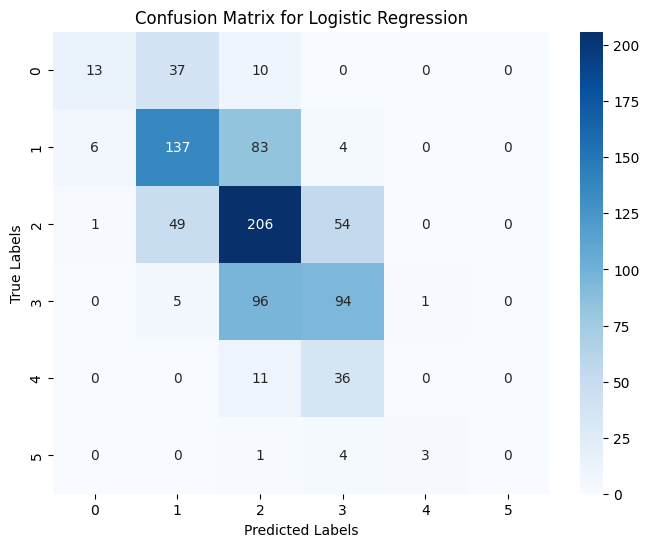

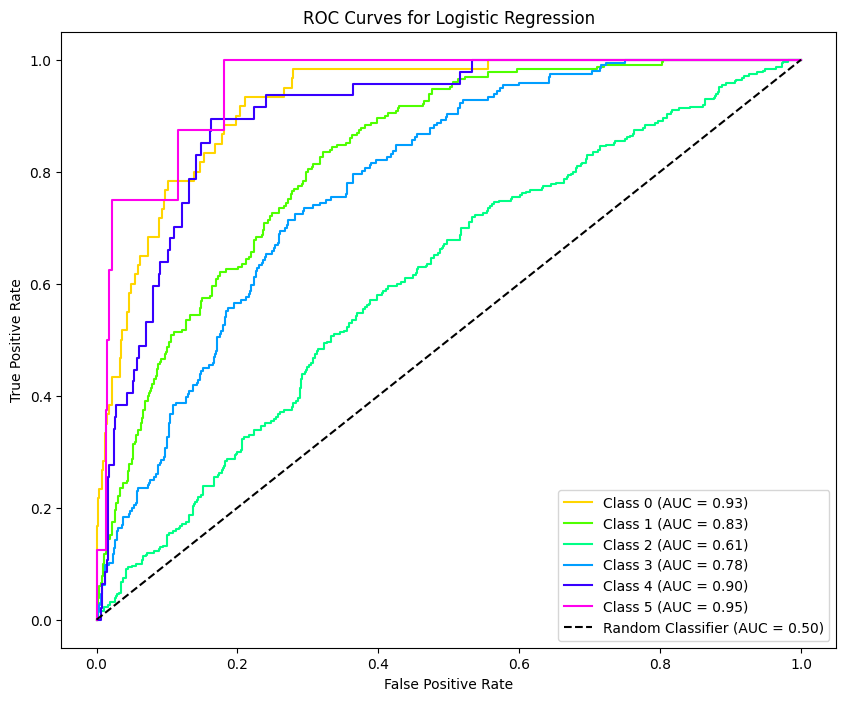

Test Accuracy: 0.5288
Performance report generated and saved as 'model_performance_report.md'.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, fbeta_score, cohen_kappa_score
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# Load and preprocess data
train_data = pd.read_csv("train.csv").dropna()
X = train_data['full_text'].values
y = train_data['score'].astype(int).values
y = y - y.min()
num_classes = len(np.unique(y))

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_eval, X_test, y_eval, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Define pipeline with Bag of Words and Logistic Regression
pipeline = Pipeline([
    ('vect', CountVectorizer(max_features=5000, ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))
])

# Define parameter grid
param_grid = {
    'vect__max_features': [5000, 10000],
    'vect__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.1, 1, 10],
    'clf__penalty': ['l2']
}

# Initialize GridSearchCV
grid = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=1)

# Fit GridSearchCV
grid_result = grid.fit(X_train, y_train)

# Get best parameters and model
best_params = grid_result.best_params_
best_model = grid_result.best_estimator_

# Predictions
y_pred_train = best_model.predict(X_train)
y_pred_eval = best_model.predict(X_eval)
y_pred_test = best_model.predict(X_test)

# Metrics
metrics = {}
for dataset, y_true, y_pred in [
    ('Train', y_train, y_pred_train),
    ('Eval', y_eval, y_pred_eval),
    ('Test', y_test, y_pred_test)
]:
    metrics[f'{dataset} Accuracy'] = accuracy_score(y_true, y_pred)
    metrics[f'{dataset} Precision (Macro)'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
    metrics[f'{dataset} Recall (Macro)'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
    metrics[f'{dataset} F1 Score (Macro)'] = fbeta_score(y_true, y_pred, beta=1, average='macro', zero_division=0)
    metrics[f'{dataset} QWK'] = cohen_kappa_score(y_true, y_pred, weights='quadratic')

metrics['Model'] = 'Logistic Regression'
performance_summary = pd.DataFrame([metrics]).set_index('Model')

# Classification Report
print("Classification Report on Test Set:\n")
print(classification_report(y_test, y_pred_test, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# ROC Curves
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
if y_test_binarized.shape[1] == 1:
    y_test_binarized = np.hstack((1 - y_test_binarized, y_test_binarized))
y_score = best_model.decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,8))
colors = sns.color_palette("hsv", num_classes)
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0,1], [0,1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.title('ROC Curves for Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Performance Report
report = "## Model Performance Summary\n\n"
report += performance_summary.to_markdown() + "\n\n"
report += "## Detailed Metrics\n\n"
report += f"### Logistic Regression\n\n"
report += classification_report(y_test, y_pred_test, zero_division=0) + "\n\n"
report += f"**Best Parameters:** {best_params}\n\n"
with open("model_performance_report.md", "w") as file:
    file.write(report)

print(f"Test Accuracy: {metrics['Test Accuracy']:.4f}")
print("Performance report generated and saved as 'model_performance_report.md'.")